# Isoconversional analysis of solid-state reactions

## Modules Library

Import all the necessary modules

In [1]:
from classes.reaction_rates import Model
from classes.input_data import Input_Data
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import csv
from scipy.misc import derivative
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.interpolate import interp1d

## User-Defined Functions

In [2]:
# Limit fitting based on the y-axis
def limit(x,y,blim,ulim):
    
    y_tmp = [i for i in y if i >= blim]                           # Bottom limit of the y-array
    x_tmp = [x[i] for i in range(len(y)) if y[i] >= blim]         # Bottom limit the x-array
    y = [i for i in y_tmp if i <= ulim]                           # Upper limit the y-array
    x = [x_tmp[i] for i in range(len(y_tmp)) if y_tmp[i] <= ulim] # Upper limit the x-array
    
    return x,y

def arrhenius(A,Ea,T):
    # k has the same units as A
    R  = 8.314              # Ideal gas constant J / (mol.K)
    k = A*np.exp(-Ea/(R*T)) # Ea in J/mol
    return k

## Plotting settings

In [3]:
graph_format   = 'png'
graph_dpi      = 300
graph_fontsize = 11
lwidth         = 3
palette        = ['#2f4b7c','#a05195','#d45087','#9AD5CA','#C97064']
palette        = ['#2f4b7c','#a05195','#9AD5CA','#C97064']
# palette      = ['#4c72b0','#dd8452','#55a868','#c44e52','#8172b3','#937860','#da8bc3','#8c8c8c','#ccb974','#64b5cd']
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

## Directories

In [4]:
CWD       = os.getcwd()                                       # current working directory
DATA      = os.path.join(CWD,'data')                          # csv data files directory
Csvs      = [os.path.join(DATA,x) for x in os.listdir(DATA) if ".csv" in x] # list all the csv files in cwd
OUTPUT    = os.path.join(CWD,'output')                        # output directory
OUTPUT    = os.path.join(OUTPUT,'iso-analysis')

## Load Data

#### Read the data
* Get the the data recursively from the CSV files in `data` directory
* Read the thermogravimetric mass, time, temperature and temperature units from each data set

#### Convert the thermogravimetric mass to the conversion fraction

$$ \alpha = \frac{m_{0}-m_{t}}{m_{0}-m_{\infty}} $$

where $m_{0}$ is the initial mass, $m_{t}$ is the mass at time $t$ and $m_{\infty}$ is the final mass of the sample. Thus, $\alpha$ expresses the fraction of the mass that has been converted at a time $t$.

#### Set the limits of the conversion fraction (working data)

#### Perform a polynomial fitting

* Fit the $t = f(a)$ curve (referred as *inverse problem*). That enables us to calculate the time for an arbitrary conversion fraction
* Fit the $a = a(t) $ curve. That enables us to calculate the conversion fraction for an arbitrary time.
* Calculate the reaction rate based on the latter fit.

#### Plot for each individual kinetic data set
* The experimental conversion fraction and its polynomial fit over time
* The reaction rate over time
* The reaction rate over fraction reacted

In [5]:
# Create a list to store the instances in data = [instance #1, instance #2, ...]
data = []

for Csv in Csvs:
    
    # Read the CSV file
    df    = pd.read_csv(Csv) # open the CSV file as dataframe
    time        = df["Time (min)"].to_numpy()         # time
    temperature = df["Temperature (C)"].to_numpy()    # temperature
    conversion  = df["Conversion"].to_numpy()         # conversion fraction
    time_units  = 'min'                               # time units
    
    # Limit the fitting region
    b_lim = 0.049 # bottom limit
    u_lim = 0.949 # upper limit
    
    # Get the updated region to fit
    t, a = limit(time, conversion, b_lim, u_lim)
    
    # Average temperature
    Ti = np.mean(temperature)
    
    # Get the instance of an empty class
    instance = Input_Data()
    # Give to the instance
    instance.time        = t
    instance.conversion  = a
    instance.temperature = Ti
    instance.dadt        = np.gradient(np.array(a),np.array(t))
    
    data.append(instance)

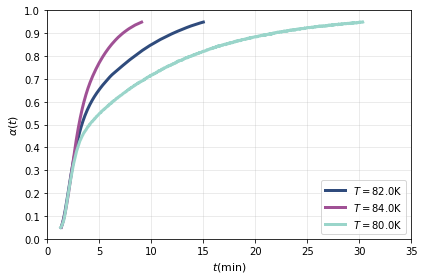

In [6]:
# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)

# Name the graph
Plot = os.path.join(GRAPH,'conversion_vs_time.png')

fig = plt.figure()
for indx, exp_data in enumerate(data):
    plt.plot(exp_data.time,exp_data.conversion,c=palette[indx], label=r'$T = $'+str(round(exp_data.temperature,0))+r'K',lw=lwidth)

plt.xlabel(r'$ t (\mathrm{min}) $', fontsize=graph_fontsize)
plt.ylabel(r'$ \alpha \left( t \right)  $', fontsize=graph_fontsize)
plt.xlim(0.0,35.0)
plt.ylim(0.0,1.0)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

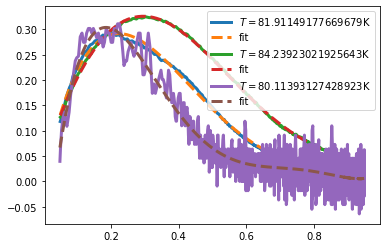

In [7]:
for exp_data in data:
    plt.plot(exp_data.conversion,exp_data.dadt,label=r'$T = $'+str(exp_data.temperature)+r'K',lw=lwidth)
    if exp_data == data[0]:
        z_deg = 4
    elif exp_data == data[1]:
        z_deg = 5
    elif exp_data == data[2]:
        z_deg = 6
    z = np.polyfit(exp_data.conversion, exp_data.dadt, z_deg)
    p = np.poly1d(z)
    plt.plot(exp_data.conversion,p(exp_data.conversion),ls='--',label='fit',lw=lwidth)
plt.legend()

In [8]:
# Get the fitted reaction rate
for exp_data in data:    
    if exp_data == data[0]:
        z_deg = 4
    elif exp_data == data[1]:
        z_deg = 5
    elif exp_data == data[2]:
        z_deg = 6
    z = np.polyfit(exp_data.conversion, exp_data.dadt, z_deg)
    p = np.poly1d(z)
    exp_data.dadt = p(exp_data.conversion)

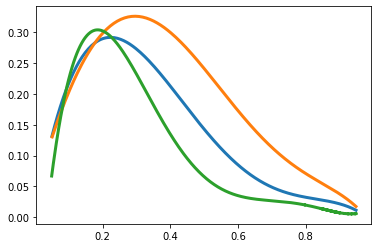

In [9]:
for exp_data in data:
    plt.plot(exp_data.conversion,exp_data.dadt,label=r'$T = $'+str(exp_data.temperature)+r'K',lw=lwidth)

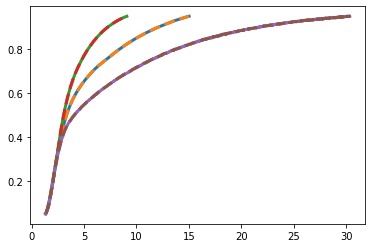

In [12]:
# CREATE ISOCONVERSIONAL LEVELS FOR CONVERSION AND TIME
data_size = [] # Size of each data set
b_value   = [] # Initial conversion for each data set
f_value   = [] # Final conversion for each data set
for exp_data in data:
    data_size.append(len(exp_data.conversion))
    b_value.append(exp_data.conversion[0])
    f_value.append(exp_data.conversion[-1])

# Define the conversion levels as the conversion with the smallest size
data_size = np.array(data_size)
a_levels  = data[np.argmin(data_size)].conversion
a_levels = np.array(a_levels)
x_interp1d = a_levels

# for the integral isoconversional method
for exp_data in data:
    x = np.array(exp_data.conversion)
    y = np.array(exp_data.time)
    f = interp1d(x, y, kind='linear',fill_value="extrapolate")
    y_interp1d = f(x_interp1d)
    exp_data.a_isoc = a_levels
    exp_data.t_isoc = y_interp1d
    
    plt.plot(exp_data.time,exp_data.conversion,lw=lwidth)
    plt.plot(exp_data.t_isoc,exp_data.a_isoc,ls="--",lw=lwidth)

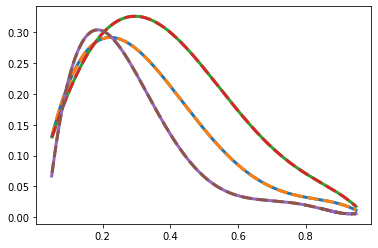

In [13]:
# for the differential isoconversional method
for exp_data in data:
    x = exp_data.conversion
    y = exp_data.dadt
    f = interp1d(x, y, kind='linear',fill_value="extrapolate")
    x_interp1d = exp_data.a_isoc
    y_interp1d = f(x_interp1d)
    
    exp_data.dadt_isoc = y_interp1d
    
    plt.plot(exp_data.conversion,exp_data.dadt,lw=lwidth)
    plt.plot(exp_data.a_isoc,exp_data.dadt_isoc,ls="--",lw=lwidth)

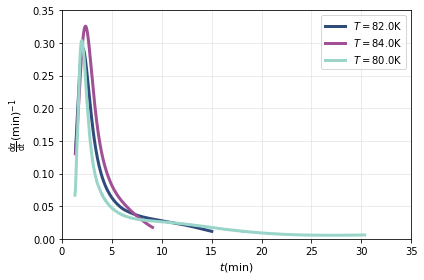

In [62]:
# Name the graph
Plot = os.path.join(GRAPH,'dadt_vs_time.png')

fig = plt.figure()
for indx, exp_data in enumerate(data):
    plt.plot(exp_data.time,exp_data.dadt,c=palette[indx], label=r'$T = $'+str(round(exp_data.temperature,0))+r'K',lw=lwidth)

plt.xlabel(r'$ t (\mathrm{min}) $', fontsize=graph_fontsize)
plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{(min)^{-1}}  $', fontsize=graph_fontsize)
plt.xlim(0.0,35.0)
plt.ylim(0.0,0.35)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

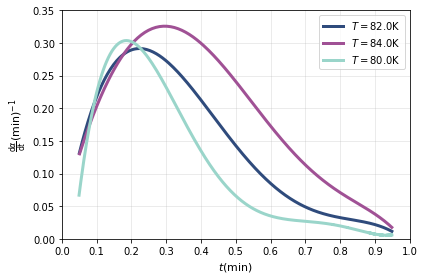

In [61]:
# Name the graph
Plot = os.path.join(GRAPH,'dadt_vs_conversion.png')

fig = plt.figure()
for indx, exp_data in enumerate(data):
    plt.plot(exp_data.conversion,exp_data.dadt,c=palette[indx], label=r'$T = $'+str(round(exp_data.temperature,0))+r'K',lw=lwidth)

plt.xlabel(r'$ t (\mathrm{min}) $', fontsize=graph_fontsize)
plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{(min)^{-1}}  $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
plt.ylim(0.0,0.35)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

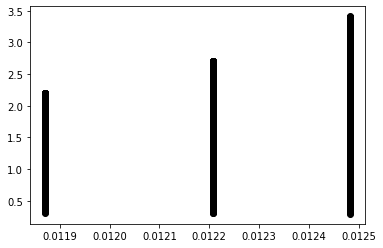

In [14]:
# IMPLEMENT THE INTEGRAL ISOCONVERSIONAL METHOD ON THE NOMRAL FIT CONVERSION DATA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Gas constant 
R = 8.3144621

# INTEGRAL ISOCONVERSIONAL METHOD FOR ILLUSTRATION PURPOSES
# Plot the natural logarithm of time over the inverse temperature

# Perform linar regression for each data set ( ln(reaction rate) vs inverse temperature )
# over all the explicitly defined conversion fraction levels

Ea        = [] # Activation energy (kJ/mol)
intercept = [] # Intercept ln[A g(a)]
MSE       = [] # Standard deviation
R2        = [] # Determination coefficient

# the conversion fraction levels that the reaction rate will be calculated for
# a_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# a_levels  = np.linspace(0.06,0.94,500)

x = [] # inverse temperature [size(data)]

for exp_data in data:
    xi = 1.0/exp_data.temperature
    x.append(xi)

x = np.array(x).reshape((-1, 1))

for indx, ai in enumerate(a_levels):
    
    y = [] # natural logarithm of time [size(data)]
    
    for exp_data in data:
        yi = np.log(exp_data.t_isoc[indx])
        y.append(yi)
    
    y = np.array(y)
    regr = LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    
    Ea.append(regr.coef_[0]*R*1.0e-3)
    intercept.append(regr.intercept_)
    MSE.append(mean_squared_error(y, y_pred))
    R2.append(r2_score(y_pred , y))
    
    plt.scatter(x,y,color='k')
#     plt.plot(x,y_pred)
#     plt.xlim(2.8e-3,3.4e-3)

lamda = np.array(intercept)

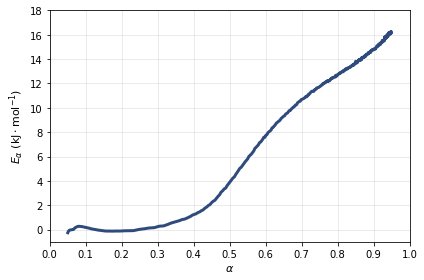

In [21]:
# Name the graph
Plot = os.path.join(GRAPH,'activation_energy_vs_conversion_IISOC.png')

fig = plt.figure()
plt.plot(a_levels,Ea,lw=lwidth,c=palette[0])
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ E_{\alpha} $ $\mathrm{(kJ \cdot mol^{-1})} $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
plt.ylim(-1.0,18.0)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

# activation energy from the integral isoconversional method
Ea_IISOC = Ea

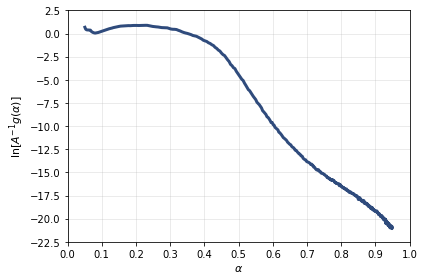

In [23]:
# Name the graph
Plot = os.path.join(GRAPH,'lamda_vs_conversion_IISOC.png')

fig = plt.figure()
plt.plot(a_levels,lamda,lw=lwidth,c=palette[0])
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ \ln{ [ A^{-1} g(\alpha) ] } $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
plt.ylim(-22.5,2.5)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

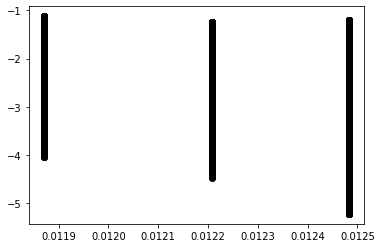

In [24]:
# IMPLEMENT THE DIFFERENTIAL ISOCONVERSIONAL METHOD ON THE NOMRAL FIT CONVERSION DATA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Gas constant 
R = 8.3144621

# INTEGRAL ISOCONVERSIONAL METHOD FOR ILLUSTRATION PURPOSES
# Plot the natural logarithm of time over the inverse temperature

# Perform linar regression for each data set ( ln(reaction rate) vs inverse temperature )
# over all the explicitly defined conversion fraction levels

Ea        = [] # Activation energy (kJ/mol)
intercept = [] # Intercept ln[A g(a)]
MSE       = [] # Standard deviation
R2        = [] # Determination coefficient

# the conversion fraction levels that the reaction rate will be calculated for
# a_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# a_levels  = np.linspace(0.06,0.94,500)

x = [] # inverse temperature [size(data)]

for exp_data in data:
    xi = 1.0/exp_data.temperature
    x.append(xi)

x = np.array(x).reshape((-1, 1))

for indx, ai in enumerate(a_levels):
    
    y = [] # natural logarithm of time [size(data)]
    
    for exp_data in data:
        yi = np.log(exp_data.dadt_isoc[indx])
        y.append(yi)
    
    y = np.array(y)
    regr = LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    
    Ea.append(-regr.coef_[0]*R*1.0e-3)
    intercept.append(regr.intercept_)
    MSE.append(mean_squared_error(y, y_pred))
    R2.append(r2_score(y_pred , y))
    
    plt.scatter(x,y,color='k')
#     plt.plot(x,y_pred)
#     plt.xlim(2.8e-3,3.4e-3)

mu = np.array(intercept)

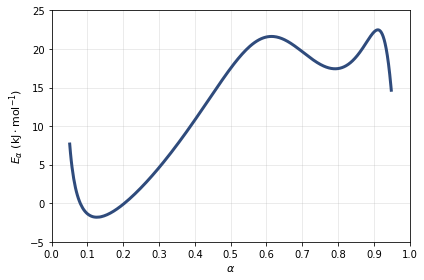

In [26]:
# Name the graph
Plot = os.path.join(GRAPH,'activation_energy_vs_conversion_DISOC.png')

fig = plt.figure()
plt.plot(a_levels,Ea,lw=lwidth,c=palette[0])
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ E_{\alpha} $ $\mathrm{(kJ \cdot mol^{-1})} $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
plt.ylim(-5.0,25.0)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

# activation energy from the integral isoconversional method
Ea_DISOC = Ea

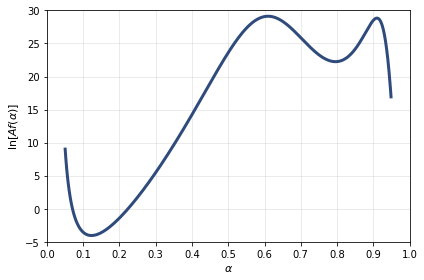

In [29]:
# Name the graph
Plot = os.path.join(GRAPH,'mu_vs_conversion_DISOC.png')

fig = plt.figure()
plt.plot(a_levels,mu,lw=lwidth,c=palette[0])
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ \ln{ [ A f \left( \alpha \right) ] } $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
plt.ylim(-5.0,30.0)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [30]:
# The names of the models supported in this code
modelnames = ["A2","A3","A4","D1","D2","D3","D4","F0","F1","F2","F3","P2","P3","P4","R2","R3"]
model_benchmark = 'P4'

In [46]:
BCM = []
# loop over the conversion
for indx, ai in enumerate(a_levels):
    
    Gold_Finger = []
    
    # Loop over all models
    for modelname in modelnames:
        
        # Pick up the model
        model = Model(modelname)
    
        gg = np.array(model.g([ai])[0])
        ff = np.array(model.f([ai])[0])
        gf = gg*ff-np.exp(mu[indx]+lamda[indx])
        
        # Model Choice Criterion
        Gold_Finger.append(np.abs(gf))
    
    # Find where the BCM is located
    BCM_loc = Gold_Finger.index(min(Gold_Finger))
    
#     BCM.append(model_benchmark)
    
    # Store the name of the BCM
    if modelnames[BCM_loc] == 'D2':
        BCM.append(model_benchmark)
    elif modelnames[BCM_loc] == 'D4':
        BCM.append(model_benchmark)
    else:
        BCM.append(modelnames[BCM_loc])

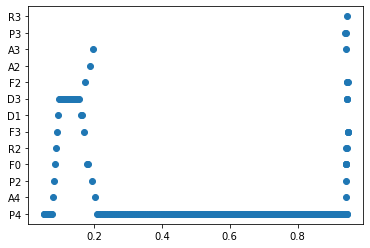

In [47]:
plt.scatter(a_levels,BCM)

(array([413.,   3.,   7.,   3.,   6.,  22.,   4.,   1.,   2.,   3.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

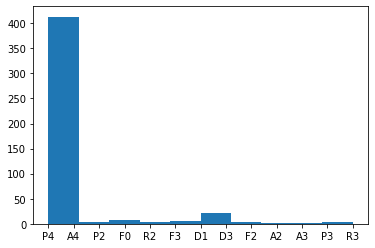

In [48]:
plt.hist(BCM)

In [49]:
A = []
for indx, ai in enumerate(a_levels):
    # Pick up the BCM for this conversion
    model = Model(BCM[indx])
#     # Based on the differential isoconversional method
#     Ai = np.exp(mu[indx])/model.f([ai])[0]
    # Based on the itegral isoconversional method
    Ai = model.g([ai])[0]/np.exp(lamda[indx])
    A.append(Ai)

[0.2409506643531814,
 0.2946500847194691,
 0.31951767796636804,
 0.33076817130094494,
 0.3372412294566252,
 0.3410293843257986,
 0.34601449748707547,
 0.35263277811360355,
 0.40741889305672474,
 0.4410708936574703,
 0.469799850185393,
 0.4975265951031464,
 0.270548928065054,
 0.07825803139327252,
 0.040455909436144306,
 0.09228088756871809,
 0.0074169041475533335,
 0.0009046519092009945,
 0.0009281554611350854,
 0.0009626933044936002,
 0.000992478835729866,
 0.001013522847059142,
 0.0010185089291636295,
 0.001040720497667596,
 0.0010704357056527637,
 0.0011042527386317914,
 0.001135913008070763,
 0.0011547603637781206,
 0.0011899288800453023,
 0.0012135066574270135,
 0.0012583556775920344,
 0.0012984221992171266,
 0.001341847386302713,
 0.011319423152619494,
 0.01169011708303849,
 0.09641560358201859,
 0.08963245625838404,
 0.07570776078074194,
 0.07819904819546719,
 0.19179395276058203,
 0.18331389030156123,
 0.2506855928721314,
 0.2872722958307842,
 0.28363323978919663,
 0.2834413995

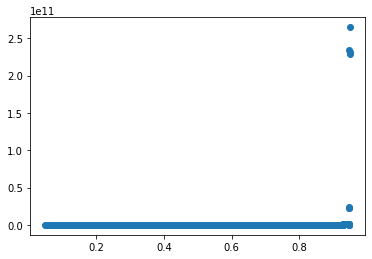

In [50]:
plt.scatter(a_levels,A)
# plt.ylim(1.0e+8,1.0e+13)
A

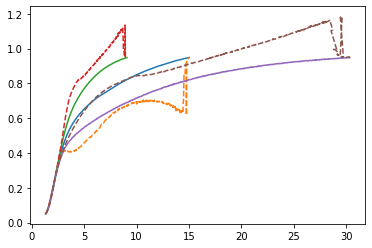

In [51]:
for exp_data in data:

    # The Arrenius constant as a function of activation energy
    k  = [arrhenius(A[i],Ea_IISOC[i]*1.0e+3,np.mean(exp_data.temperature)) for i in range(len(A))]

    conversion_predicted = []
    for indx, modelname in enumerate(BCM):

        # Choose the model from the gold finger
        model = Model(BCM[indx])
#         model = Model(model_benchmark)

        # Isoconversional time
        ti = exp_data.t_isoc[indx]

        # The Arrhenius rate for this conversion
        ki = k[indx]

        # Predicted Conversion on this time
        ai = model.alpha([ti],ki)[0]

        conversion_predicted.append(ai)

    plt.plot(exp_data.time,exp_data.conversion)
    plt.plot(exp_data.t_isoc,conversion_predicted,ls="--")

In [ ]:
# Plot the reaction rate versus time (based on the normal fit)
# and indicate the conversion fraction on the graph at each time

# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Get just the name of the csv files
csv_names = [x.split('.csv')[0] for x in os.listdir(DATA) if ".csv" in x]
    
# Plot the reaction rate from the normal fit
for indx, exp_data in enumerate(data):
    
    # Name the graph
    Plot = os.path.join(GRAPH,csv_names[indx]+'_dadt_vs_time.png')
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    # Plot rhe reaction rate
    xplot = exp_data.t_nrmfit
    yplot = exp_data.rrate
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    ax1.set_xlabel(r'$ t (\mathrm{'+exp_data.time_units+'}) $', fontsize=graph_fontsize)
    ax1.set_ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+exp_data.time_units+')^{-1}}  $', fontsize=graph_fontsize)
    ax1.set_xlim(0.0,max(xplot))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax1.locator_params(axis='x', nbins=10)
    ax1.tick_params(direction='out', axis='both', labelsize=graph_fontsize)
    ax1.xaxis.set_minor_locator(MultipleLocator(10)) # make minor ticks multiples of 10
#         ax1.legend()
        
    # the conversion fraction levels that the reaction rate will be calculated for
    a_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # the corresponding times for the above conversion
    t_levels = [exp_data.t_poly(i) for i in a_levels]

    # t_locations = the locations in the "normal fit" arrays
    #               that correspond to the above defined times
    t_locations = []
    for i in t_levels:
        t_norm = [abs(i-j) for j in exp_data.t_nrmfit]
        t_loc  = np.argmin(t_norm)
        t_locations.append(t_loc)

    # the new time levels based on the 'normal fit'
    t_levels = [exp_data.t_nrmfit[i] for i in t_locations]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(t_levels)
    ax2.set_xticklabels(a_levels)
    ax2.set_xlabel(r'$ \alpha $', fontsize=graph_fontsize)
    ax2.tick_params(direction='out', axis='x', labelsize=graph_fontsize-5)
    ax1.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [ ]:
# Plot and save the reaction rate versus conversion (based on the normal fit)
# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Get just the name of the csv files
csv_names = [x.split('.csv')[0] for x in os.listdir(DATA) if ".csv" in x]
    
# Plot the reaction rate from the normal fit
for indx, exp_data in enumerate(data):
    
    # Name the graph
    Plot = os.path.join(GRAPH,csv_names[indx]+'_dadt_vs_conversion.png')
    
    fig = plt.figure()
    # Plot the conversion fraction versus time
    xplot = exp_data.a_nrmfit
    yplot = exp_data.rrate
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    
    plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
    plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+exp_data.time_units+')^{-1}}  $', fontsize=graph_fontsize)
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,max(yplot))
    plt.locator_params(axis='both', nbins=10)
    plt.grid(b=True, which='major', axis='both', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [ ]:
# Plot and save the experimentally recorded conversion versus time for all data
# Define the maximum value in the xaxis
xmax = 35.0

# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Name the graph
Plot = os.path.join(GRAPH,'a_vs_t.png')

# Plot the reaction rate from the normal fit
fig = plt.figure()
for indx, exp_data in enumerate(data):
    
    # Plot the conversion fraction versus time
    xplot = exp_data.time
    yplot = exp_data.conversion
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    
plt.xlabel(r'$ t (\mathrm{'+exp_data.time_units+'}) $', fontsize=graph_fontsize)
plt.ylabel(r'$ \alpha  $', fontsize=graph_fontsize)
plt.xlim(0.0,xmax)
plt.ylim(0.0,1.0)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [ ]:
# Plot and save the normal fit reaction rate versus time for all data
# Define the maximum value in the xaxis and yaxis
xmax = 35.0
ymax = 0.45

# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Name the graph
Plot = os.path.join(GRAPH,'dadt_vs_t.png')

# Plot the reaction rate from the normal fit
fig = plt.figure()
for indx, exp_data in enumerate(data):
    
    # Plot the conversion fraction versus time
    xplot = exp_data.t_nrmfit
    yplot = exp_data.rrate
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    
plt.xlabel(r'$ t (\mathrm{'+exp_data.time_units+'}) $', fontsize=graph_fontsize)
plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+exp_data.time_units+')^{-1}}  $', fontsize=graph_fontsize)
plt.xlim(0.0,xmax)
plt.ylim(0.0,ymax)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [ ]:
# Plot and save the normal fit reaction rate versus conversion for all data
# Define the maximum value in the xaxis and yaxis
xmax = 1.0
ymax = 0.45

# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Name the graph
Plot = os.path.join(GRAPH,'dadt_vs_a.png')

# Plot the reaction rate from the normal fit
fig = plt.figure()
for indx, exp_data in enumerate(data):
    
    # Plot the conversion fraction versus time
    xplot = exp_data.a_nrmfit
    yplot = exp_data.rrate
    plt.plot(xplot,yplot,lw=lwidth,c=palette[indx],label=r'$ < T > = '+str(round(np.mean(exp_data.temperature),2))+' ^{o}C$')
    
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ \frac{ \mathrm{d} \alpha }{ \mathrm{d} t } \mathrm{('+exp_data.time_units+')^{-1}}  $', fontsize=graph_fontsize)
plt.xlim(0.0,xmax)
plt.ylim(0.0,ymax)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [ ]:
# INTEGRAL ISOCONVERSIONAL METHOD FOR ILLUSTRATION PURPOSES
# Plot the natural logarithm of time over the inverse temperature

for indx, exp_data in enumerate(data):
    
    # the conversion fraction levels that the reaction rate will be calculated for
    a_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
    # the corresponding times
    t_levels = [exp_data.t_poly(i) for i in a_levels]
    
    # t_locations = the locations in the "normal fit" arrays
    #               that correspond to the above defined times
    t_locations = []
    for i in t_levels:
        t_norm = [abs(i-j) for j in exp_data.t_nrmfit]
        t_loc  = np.argmin(t_norm)
        t_locations.append(t_loc)        

    y = [] # it will hold the inverse temperature [size(t_location)]
    x = [] # it will hold the natural logarithm of the reaction rate [size(t_location)]

    for ti in t_locations:
        # calculate the reactin rate for a particular conversion level
        y.append(exp_data.t_nrmfit[ti])
        # draw out the corresponding temperature
        x.append(np.mean(exp_data.temperature))

    x = [1.0/i for i in x]
    y = [np.log(i) for i in y]

    for i in range(len(t_locations)):
        # comment: in this plot the temperature remains the same so as y[i]
        #          fills up the graph with reaction rates at different conversions
        #          the different colours correspond to different temperatures
        #          while the different marker styles correspond to different conversion levels
        plt.scatter(x[i],y[i],c=palette[indx],marker=filled_markers[i],s=70,edgecolors='black')
    

# Plot legends
for i in range(len(t_locations)):
    plt.scatter(x[i],y[i],c=palette[indx],marker=filled_markers[i],s=70,edgecolors='black', label=r'$\alpha ='+str(a_levels[i])+' $')

# limits for the graph to have it more generic
T_lim = []

for indx, exp_data in enumerate(data):
    T_lim.append(np.mean(exp_data.temperature))

T_lim = [1.0/i for i in T_lim]

plt.xlabel(r'$  1/T \mathrm{(K^{-1})} $', fontsize=graph_fontsize)
plt.ylabel(r'$ \ln{ (t) } $ $\mathrm{('+data[0].time_units+')} $', fontsize=graph_fontsize)
xmin = np.min(T_lim)-0.1*np.mean(T_lim)
xmax = np.max(T_lim)+0.1*np.mean(T_lim)
plt.xlim(xmin,xmax)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:
# Create a class to store the locations
# of the 'normal fit' time array where the conversion fraction
# is defined explicitly
class t_locs:

    def __init__(self, t_locations):
        self.t_locations = t_locations

# Define the conversion fraction levels where the isoconverional method
# will be implemented at
a_levels = np.linspace(b_lim,u_lim,2000)

# Create an instances array
# t_indx = [instance #1, instance #2, ...]

t_indx = []
for indx, exp_data in enumerate(data):
    
    # The corresponding times of the a_levels
    t_levels = [exp_data.t_poly(i) for i in a_levels]

    # t_locations = the locations in the "normal fit" arrays
    #               that correspond to the above defined times
    t_locations = []
    for i in t_levels:
        t_norm = [abs(i-j) for j in exp_data.t_nrmfit]
        t_loc  = np.argmin(t_norm)
        t_locations.append(t_loc)
    
    # Create the instances
    t_indx.append(t_locs(t_locations))

In [ ]:
# IMPLEMENT THE INTEGRAL ISOCONVERSIONAL METHOD ON THE NOMRAL FIT CONVERSION DATA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Perform linar regression for each data set ( ln(reaction rate) vs inverse temperature )
# over all the explicitly defined conversion fraction levels

Ea        = [] # Activation energy (kJ/mol)
intercept = [] # Intercept ln[A g(a)]
MSE       = [] # Standard deviation
R2        = [] # Determination coefficient

for i_isoc in range(len(t_locations)):

    y = []

    for indx, exp_data in enumerate(data):
        ti = t_indx[indx].t_locations[i_isoc]
        y.append(exp_data.t_nrmfit[ti])

    # natural logarithm of time
    y = [np.log(i) for i in y]

    # inverse temperature
    x = []
    for indx, exp_data in enumerate(data):
        x.append(np.mean(exp_data.temperature))

    x = [1.0/i for i in x]

    # Calling DataFrame constructor after zipping 
    # both lists, with columns specified
    df = pd.DataFrame(list(zip(x,y)), columns =['x','y'],dtype=float)

    regr = LinearRegression()
    x_train = np.asanyarray(df[['x']])
    y_train = np.asanyarray(df[['y']])
    regr.fit (x_train, y_train)

    y_pred = regr.predict(x_train)

    Ea.append(regr.coef_[0][0])
    intercept.append(regr.intercept_[0])
    MSE.append(mean_squared_error(y_train, y_pred))
    R2.append(r2_score(y_pred , y_train))

# Gas constant 
R = 8.3144621

Ea = [i*R for i in Ea]

In [ ]:
# Plot the acivation energy versus conversion

# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Name the graph
Plot = os.path.join(GRAPH,'Ea_vs_a_integral_isoc.png')


fig = plt.figure()
xplot = a_levels
yplot = Ea
plt.plot(xplot,yplot,lw=lwidth,c=palette[0])
# plt.fill_between(np.array(xplot), np.array(yplot)-np.array(MSE), np.array(yplot)+np.array(MSE))
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ E_{\alpha} $ $\mathrm{(kJ \cdot mol^{-1})} $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
# plt.ylim(0.0,)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
# plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)

In [ ]:
# Plot the acivation energy versus conversion

# Create necessary output directories
GRAPH = os.path.join(OUTPUT,'graphs') # output directory for the graphs
if not os.path.exists(GRAPH): os.makedirs(GRAPH)
    
# Name the graph
Plot = os.path.join(GRAPH,'intercept_vs_a_integral_isoc.png')


fig = plt.figure()
xplot = a_levels
yplot = intercept
plt.plot(xplot,yplot,lw=lwidth,c=palette[0])
plt.xlabel(r'$ \alpha $', fontsize=graph_fontsize)
plt.ylabel(r'$ \ln{ [ A^{-1} g(\alpha) ] } $', fontsize=graph_fontsize)
plt.xlim(0.0,1.0)
# plt.ylim(0.0,)
plt.locator_params(axis='both', nbins=10)
plt.grid(b=True, which='major', axis='both', alpha=0.3)
# plt.legend()
plt.tight_layout()
plt.savefig(Plot, format=graph_format, dpi=graph_dpi)